# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [0]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=5)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=5)

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 12, 5)
        self.fc1 = nn.Linear(12 * 5 * 5, 24)
        self.fc2 = nn.Linear(24, 10)
        self.activation_function = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.activation_function(self.conv1(x)))
        x = self.pool(self.activation_function(self.conv2(x)))
        x = x.view(-1, 12 * 5 * 5)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN()
model.to(device)

print(model)

CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=300, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=10, bias=True)
  (activation_function): ReLU()
)


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)
loss_fn = torch.nn.CrossEntropyLoss()


In [0]:
def train(epochs, validate=False):
    losses = []
    for epoch in range(epochs):
        print('Epoch ' + str(epoch + 1) + ':')
        train_sub_len = int(len(train_loader)/epochs)
        validate_indices = []
        if validate:
            start = epoch * train_sub_len
            end = (epoch + 1) * train_sub_len
            validate_indices = range(start, end)
            validate_set = list(train_loader) 
            
        correct = 0
        total = 0
        
        running_loss = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if not validate or i not in validate_indices:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

                running_loss += loss.item()
            
            if (i % train_sub_len == train_sub_len - 1) and (i not in validate_indices): 
                losses.append(running_loss / train_sub_len)
                running_loss = 0.0

                
        print('  Training accuracy: %d %%' % (
            100 * correct / total))
        
        if validate:
            correct = 0
            total = 0
            with torch.no_grad():
              for i in validate_indices:
                inputs, labels = validate_set[i]
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            print('  Validation accuracy: %d %%' % (
                    100 * correct / total))        
            
    plt.plot(losses)
    plt.title("Loss")
    plt.show()
            


Epoch 1:
  Training accuracy: 14 %
  Validation accuracy: 22 %
Epoch 2:
  Training accuracy: 32 %
  Validation accuracy: 37 %
Epoch 3:
  Training accuracy: 39 %
  Validation accuracy: 41 %
Epoch 4:
  Training accuracy: 43 %
  Validation accuracy: 46 %
Epoch 5:
  Training accuracy: 46 %
  Validation accuracy: 50 %
Epoch 6:
  Training accuracy: 49 %
  Validation accuracy: 49 %
Epoch 7:
  Training accuracy: 50 %
  Validation accuracy: 52 %
Epoch 8:
  Training accuracy: 52 %
  Validation accuracy: 53 %
Epoch 9:
  Training accuracy: 53 %
  Validation accuracy: 54 %
Epoch 10:
  Training accuracy: 54 %
  Validation accuracy: 58 %
Epoch 11:
  Training accuracy: 55 %
  Validation accuracy: 56 %
Epoch 12:
  Training accuracy: 57 %
  Validation accuracy: 58 %
Epoch 13:
  Training accuracy: 57 %
  Validation accuracy: 59 %
Epoch 14:
  Training accuracy: 58 %
  Validation accuracy: 59 %
Epoch 15:
  Training accuracy: 59 %
  Validation accuracy: 61 %


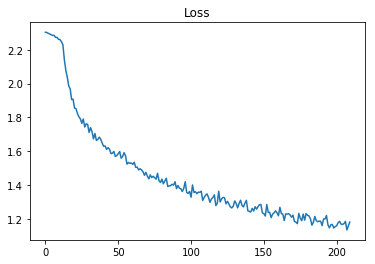

In [0]:
train(15, validate=True)

In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

print('accuracy: %d %%' % (
    100 * correct / total))

accuracy: 57 %


In [0]:
# Apenas adicionar as camadas de convolução com MaxPool2D ao modelo já melhorou significativamente a acurácia alcançada após o treinamento
# Entretanto, a generalização não foi tão acelerada quanto o aprendizado do conjunto de treino, o que ocasionou um bias cada vez maior
# Assim sendo, a arquitetura e os parâmetros da rede foram simplificados até que se chegasse a um resultado com melhor generalização do aprendizado